#**BORDER CROSSING AND ENTRY**
# Import Libraries Preferences and Helper Funtion

DATASETURL=https://catalog.data.gov/dataset/border-crossing-entry-data-683ae







Libraries

In [43]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Preferences

In [44]:
DATASET = "Border_Crossing_Entry_Data.csv"

#Load Data
data = pd.read_csv(DATASET)

#Preview data
data.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Latitude,Longitude,Point
0,Roma,Texas,2310,US-Mexico Border,Dec 2023,Buses,46,26.404,-99.019,POINT (-99.018981 26.403928)
1,Del Rio,Texas,2302,US-Mexico Border,Dec 2023,Trucks,6552,29.327,-100.928,POINT (-100.927612 29.326784)
2,Roma,Texas,2310,US-Mexico Border,Nov 2023,Trucks,3753,26.404,-99.019,POINT (-99.018981 26.403928)
3,Douglas,Arizona,2601,US-Mexico Border,Oct 2023,Buses,13,31.334,-109.560,POINT (-109.560344 31.334043)
4,Beecher Falls,Vermont,206,US-Canada Border,Aug 2023,Trucks,422,45.013,-71.505,POINT (-71.505309 45.013411)


Helper Function

In [45]:
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', font='serif')


In [46]:
print("Initial Data Info:")
data.info()

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394866 entries, 0 to 394865
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Port Name  394866 non-null  object 
 1   State      394866 non-null  object 
 2   Port Code  394866 non-null  int64  
 3   Border     394866 non-null  object 
 4   Date       394866 non-null  object 
 5   Measure    394866 non-null  object 
 6   Value      394866 non-null  int64  
 7   Latitude   394866 non-null  float64
 8   Longitude  394866 non-null  float64
 9   Point      394866 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 30.1+ MB


In [47]:
print("\nMissing Values:\n", data.isnull().sum())


Missing Values:
 Port Name    0
State        0
Port Code    0
Border       0
Date         0
Measure      0
Value        0
Latitude     0
Longitude    0
Point        0
dtype: int64


# DATA CLEANING AND PREPRCOSSING

In [48]:
#Convert date to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

#Drop duplicates if any
if 'Point' in data.columns:
    data.drop(columns=['Point'], inplace=True)

# Handle missing values
data.drop_duplicates(inplace=True)

# Convert column names to lowercase
data.dropna(subset=['Port Name', 'State', 'Border'], inplace=True)


data.columns = data.columns.str.lower().str.replace(' ', '_')
# Remove any non-numeric characters if any
data['value'] = pd.to_numeric(data['value'], errors='coerce')

# Filter out unrealistic values
data = data[data['value'] > 0]

# Reset index after cleaning
data.reset_index(drop=True, inplace=True)
data = data.sort_values(by='port_name').reset_index(drop=True)

# Preview result
print("\nCleaned Data Info:")
print(data.info())
print(data.head())

# Save Processed data
data.to_csv("processed.csv", index=False)


Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272454 entries, 0 to 272453
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   port_name  272454 non-null  object        
 1   state      272454 non-null  object        
 2   port_code  272454 non-null  int64         
 3   border     272454 non-null  object        
 4   date       272454 non-null  datetime64[ns]
 5   measure    272454 non-null  object        
 6   value      272454 non-null  int64         
 7   latitude   272454 non-null  float64       
 8   longitude  272454 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 18.7+ MB
None
  port_name   state  port_code            border       date  \
0     Alcan  Alaska       3104  US-Canada Border 2011-02-01   
1     Alcan  Alaska       3104  US-Canada Border 2009-08-01   
2     Alcan  Alaska       3104  US-Canada Border 2007-05-01   
3  

# Data Visualization

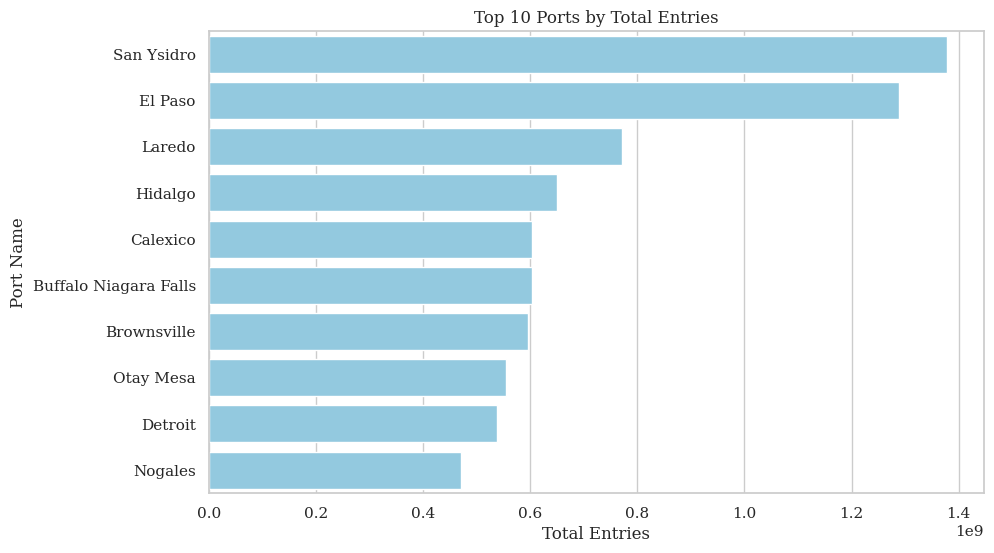

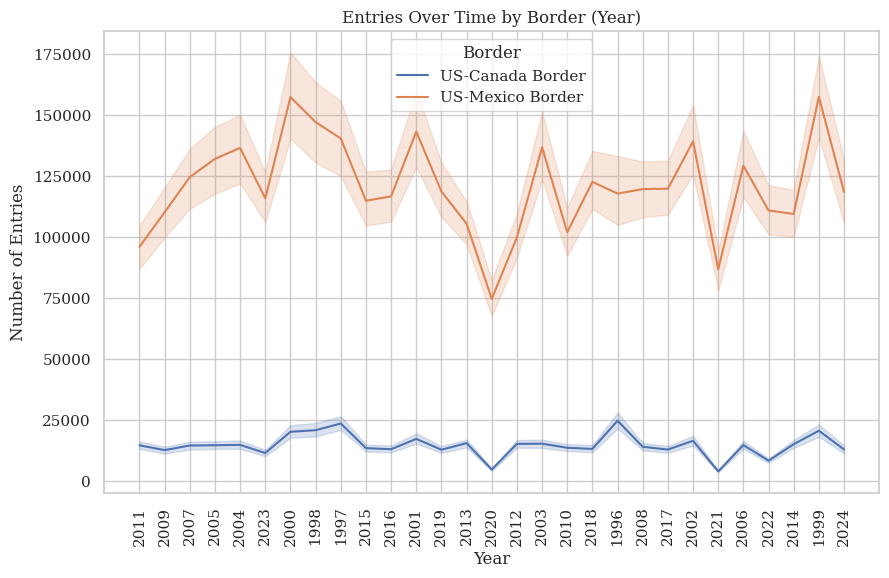

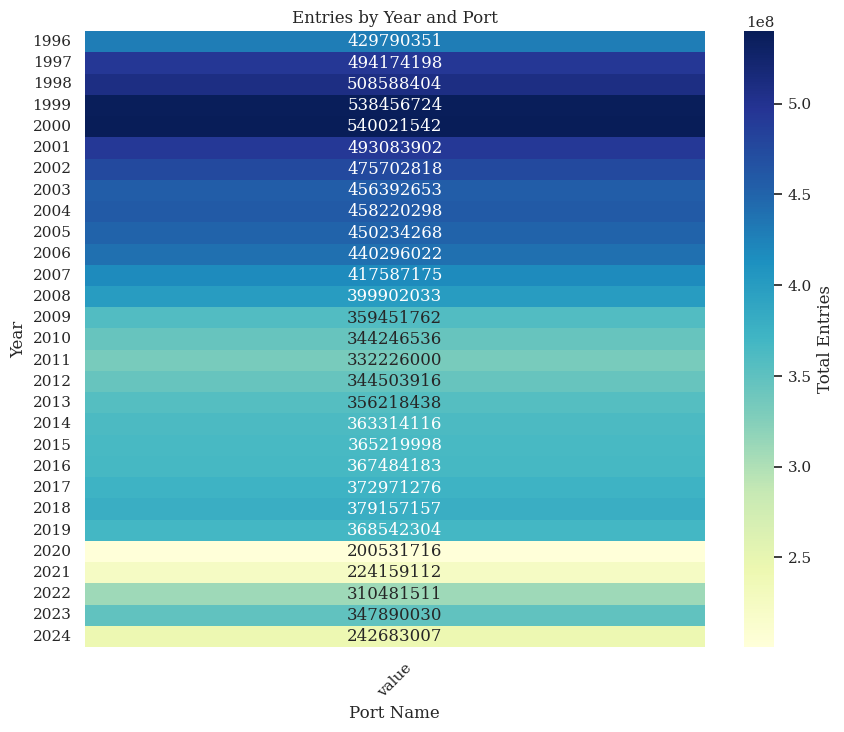

In [49]:
data.dropna(subset=['date'], inplace=True)
data['month_year'] = data['date'].dt.to_period('M').astype(str)
data['year'] = data['date'].dt.to_period('Y').astype(str)


#Bar Plot sum of entries by Port
plt.figure(figsize=(10, 6))
port_values = data.groupby('port_name')['value'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=port_values.values, y=port_values.index, color='skyblue')
plt.title('Top 10 Ports by Total Entries')
plt.xlabel('Total Entries')
plt.ylabel('Port Name')
plt.show()


monthly_data = data.groupby(['month_year', 'port_name'])['value'].sum().unstack().fillna(0)
yearly_data = data.groupby(['year', 'port_name'])['value'].sum().unstack().fillna(0)

# Line plot of entries over time (year)
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='year', y='value', hue='border', marker=" ")
plt.title('Entries Over Time by Border (Year)')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.xticks(rotation=90)
plt.legend(title='Border')
plt.show()


# Heatmap: Entries by Year and Port
yearly_sums = data.groupby('year')['value'].sum()
yearly_sums_df = yearly_sums.reset_index()
heatmap_data = yearly_sums_df.pivot_table(values='value', index='year')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.0f', cbar_kws={'label': 'Total Entries'})
plt.title('Entries by Year and Port')
plt.xlabel('Port Name')
plt.ylabel('Year')
plt.xticks(rotation=45)
plt.show()



# Model Development

In [ ]:
data['year'] = data['date'].dt.year

#Define features
X = data[['value', 'year']]
y = data['border'].factorize()[0]

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}


# Train and evaluate each model
for border_crossing, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Save the model
    with open(f'{border_crossing.replace(" ", "_")}.pkl', 'wb') as file:
        pickle.dump(model, file)

    print(f"{border_crossing} model has been trained and saved as {border_crossing.replace(' ', '_')}.pkl.")


Logistic Regression model has been trained and saved as Logistic_Regression.pkl.
Random Forest model has been trained and saved as Random_Forest.pkl.


# Model Evaluation

In [ ]:
# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_filenames = ["Data/Logistic_Regression.pkl", "Data/Random_Forest.pkl", "Data/SVM.pkl", "Data/Decision_Tree.pkl", "Data/K-Nearest_Neighbors.pkl"]
results = {}

for model_file in model_filenames:

    # Load the model
    with open(model_file, 'rb') as file:
        model = pickle.load(file)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Classification report
    class_report = classification_report(y_test, y_pred, target_names=data['border'].unique(), output_dict=True)

    # Store the results
    border_crossing = model_file.replace('.pkl', '').replace('_', ' ')
    results[border_crossing] = {
        "accuracy": accuracy,
        "classification_report": class_report
    }

    # Print the results
    print(f"Model: {border_crossing}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data['border'].unique(), yticklabels=data['border'].unique())
    plt.title(f'Confusion Matrix for {border_crossing}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Model Evaluation Documentation
eval_df = pd.DataFrame.from_dict({
    border_crossing: {
        "Accuracy": res['accuracy'],
        "Precision": res['classification_report']['weighted avg']['precision'],
        "Recall": res['classification_report']['weighted avg']['recall'],
        "F1-Score": res['classification_report']['weighted avg']['f1-score']
    }
    for border_crossing, res in results.items()
}, orient='index')

eval_df.to_csv('datasets/model_evaluation_results.csv', index=False)
print("\nModel Evaluation Results saved to 'datasets/model_evaluation_results.csv'.")

# Print final evaluation table
print(eval_df)
